# Learning MLPipelines using spark

Example for writing functions that handles errors. We use this function to
convert each element of the row to double.

In [83]:
def typeConvert(value):
    try:
        return float(value)
    except ValueError:
        return value



In [84]:
path = '/Users/vishnu/Documents/datasets/myexperiments/adult/adult.data'
rawData = (sc.textFile(path)
           .map(lambda x : x.split(","))
           .map(lambda row:  [typeConvert(x) for x in row])
            )    
rawData.first()

[39.0,
 ' State-gov',
 77516.0,
 ' Bachelors',
 13.0,
 ' Never-married',
 ' Adm-clerical',
 ' Not-in-family',
 ' White',
 ' Male',
 2174.0,
 0.0,
 40.0,
 ' United-States',
 ' <=50K']

In [85]:
newRawData = (sc.textFile(path)
           .map(lambda x : x.split(","))
           .map(lambda x : len(x))
           .distinct()
           .collect()
             )

In [86]:
print(newRawData)

[1, 15]


In [87]:
newRawData = (sc.textFile(path)
           .map(lambda x : x.split(","))
           .filter(lambda x : len(x)==1)
            .take(10) )
print(newRawData) 

[['']]


In [88]:
rawData = (sc.textFile(path)
           .map(lambda x : x.split(","))
           .filter(lambda x : len(x)==15)
           .map(lambda l : [typeConvert(x) for x in l])
            )

In [89]:
rawData.first()

[39.0,
 ' State-gov',
 77516.0,
 ' Bachelors',
 13.0,
 ' Never-married',
 ' Adm-clerical',
 ' Not-in-family',
 ' White',
 ' Male',
 2174.0,
 0.0,
 40.0,
 ' United-States',
 ' <=50K']

# Creating Dataframe

In [90]:
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType ,DoubleType ,FloatType

In [91]:
schema = StructType([
    StructField("age",FloatType(),True),
    StructField("workclass",StringType(),True),
    StructField("fnlwgt",DoubleType(),True),
    StructField("education",StringType(),True),
    StructField("unknown",StringType(),True),  
    StructField("marital_status",StringType(),True),
    StructField("occupation",StringType(),True),
    StructField("relationship",StringType(),True),
    StructField("race",StringType(),True),
    StructField("sex",StringType(),True),
    StructField("capital_gain",DoubleType(),True),
    StructField("capital_loss",DoubleType(),True),
    StructField("hours_per_week",DoubleType(),True),
    StructField("native_country",StringType(),True),
    StructField("income",StringType(),True)
])

In [92]:
 # Create a DataFrame by applying the schema to the RDD and print the schema

In [93]:
rawdf = sqlContext.createDataFrame(rawData, schema)

In [94]:
rawdf.printSchema()

root
 |-- age: float (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- unknown: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [95]:
rawdf = rawdf.drop('unknown')




#rawdf.groupBy("workclass").count().show()
rawdf.groupBy("workclass").count().show()

+-----------------+-----+
|        workclass|count|
+-----------------+-----+
|      Federal-gov|  960|
|        State-gov| 1298|
|        Local-gov| 2093|
|     Self-emp-inc| 1116|
|      Without-pay|   14|
|     Never-worked|    7|
| Self-emp-not-inc| 2541|
|                ?| 1836|
|          Private|22696|
+-----------------+-----+



In [96]:
workclass = rawdf.groupBy("workclass").count().map(lambda x:(x[0],x[1])).takeOrdered(10,lambda x:-x[1])
print(workclass)


[(' Private', 22696), (' Self-emp-not-inc', 2541), (' Local-gov', 2093), (' ?', 1836), (' State-gov', 1298), (' Self-emp-inc', 1116), (' Federal-gov', 960), (' Without-pay', 14), (' Never-worked', 7)]


In [97]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(data):
    values =  [x1[1] for x1 in data] 
    labels = [x1[0] for x1 in data]
    plt.barh(range(len((values))),values,color='blue')
    plt.yticks(range(len(values)),labels)
    plt.show()

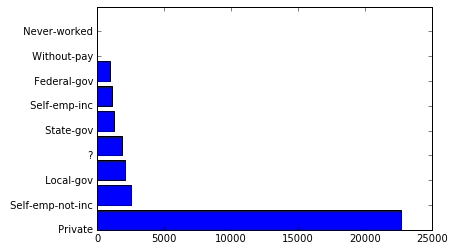

In [98]:
plot(workclass)

In [99]:
from pyspark.sql.functions import *
rawdf.groupBy("native_country").count().orderBy("count", ascending=False).show()

+-------------------+-----+
|     native_country|count|
+-------------------+-----+
|      United-States|29170|
|             Mexico|  643|
|                  ?|  583|
|        Philippines|  198|
|            Germany|  137|
|             Canada|  121|
|        Puerto-Rico|  114|
|        El-Salvador|  106|
|              India|  100|
|               Cuba|   95|
|            England|   90|
|            Jamaica|   81|
|              South|   80|
|              China|   75|
|              Italy|   73|
| Dominican-Republic|   70|
|            Vietnam|   67|
|          Guatemala|   64|
|              Japan|   62|
|             Poland|   60|
+-------------------+-----+
only showing top 20 rows



In [100]:
rawdf.groupBy("occupation").count().show(truncate=False)

+------------------+-----+
|occupation        |count|
+------------------+-----+
| Transport-moving |1597 |
| Other-service    |3295 |
| Adm-clerical     |3770 |
| Machine-op-inspct|2002 |
| Tech-support     |928  |
| Protective-serv  |649  |
| Prof-specialty   |4140 |
| Sales            |3650 |
| Craft-repair     |4099 |
| Handlers-cleaners|1370 |
| Priv-house-serv  |149  |
| Armed-Forces     |9    |
| Farming-fishing  |994  |
| Exec-managerial  |4066 |
| ?                |1843 |
+------------------+-----+



In [101]:
rawdf = rawdf.na.replace(['?'],['Private'],'workclass')
rawdf = rawdf.na.replace(['?'],['Private'],'native_country')


In [102]:
rawdf.groupBy("workclass").count().show()

+-----------------+-----+
|        workclass|count|
+-----------------+-----+
|      Federal-gov|  960|
|        State-gov| 1298|
|        Local-gov| 2093|
|     Self-emp-inc| 1116|
|      Without-pay|   14|
|     Never-worked|    7|
| Self-emp-not-inc| 2541|
|                ?| 1836|
|          Private|22696|
+-----------------+-----+



In [103]:
rawdf.groupBy("native_country").count().orderBy("count",ascending=False).show()

+-------------------+-----+
|     native_country|count|
+-------------------+-----+
|      United-States|29170|
|             Mexico|  643|
|                  ?|  583|
|        Philippines|  198|
|            Germany|  137|
|             Canada|  121|
|        Puerto-Rico|  114|
|        El-Salvador|  106|
|              India|  100|
|               Cuba|   95|
|            England|   90|
|            Jamaica|   81|
|              South|   80|
|              China|   75|
|              Italy|   73|
| Dominican-Republic|   70|
|            Vietnam|   67|
|          Guatemala|   64|
|              Japan|   62|
|             Poland|   60|
+-------------------+-----+
only showing top 20 rows



In [104]:
from pyspark.ml.feature import *

In [105]:
from pyspark.ml.feature import *
def indexStringColumns(df,cols):
    tempdf = df
    for col in cols:
        stringIndexer = StringIndexer(inputCol=col,outputCol=col+"-num")
        si_model = stringIndexer.fit(tempdf)
        tempdf = si_model.transform(tempdf).drop(col)
        tempdf = tempdf.withColumnRenamed(col+"-num",col)
    return tempdf

In [106]:
cols = {"workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"}
dfnumeric = indexStringColumns(rawdf,cols)
print(cols)

{'race', 'education', 'occupation', 'sex', 'relationship', 'income', 'marital_status', 'workclass', 'native_country'}


In [107]:
(rawdf.select("workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income")
      .show())

+-----------------+-------------+--------------------+------------------+--------------+-------------------+-------+--------------+------+
|        workclass|    education|      marital_status|        occupation|  relationship|               race|    sex|native_country|income|
+-----------------+-------------+--------------------+------------------+--------------+-------------------+-------+--------------+------+
|        State-gov|    Bachelors|       Never-married|      Adm-clerical| Not-in-family|              White|   Male| United-States| <=50K|
| Self-emp-not-inc|    Bachelors|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male| United-States| <=50K|
|          Private|      HS-grad|            Divorced| Handlers-cleaners| Not-in-family|              White|   Male| United-States| <=50K|
|          Private|         11th|  Married-civ-spouse| Handlers-cleaners|       Husband|              Black|   Male| United-States| <=50K|
|          Private|    Bach

In [108]:
(dfnumeric.select("workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income")
      .show())

+---------+---------+--------------+----------+------------+----+---+--------------+------+
|workclass|education|marital_status|occupation|relationship|race|sex|native_country|income|
+---------+---------+--------------+----------+------------+----+---+--------------+------+
|      4.0|      2.0|           1.0|       3.0|         1.0| 0.0|0.0|           0.0|   0.0|
|      1.0|      2.0|           0.0|       2.0|         0.0| 0.0|0.0|           0.0|   0.0|
|      0.0|      0.0|           2.0|       9.0|         1.0| 0.0|0.0|           0.0|   0.0|
|      0.0|      5.0|           0.0|       9.0|         0.0| 1.0|0.0|           0.0|   0.0|
|      0.0|      2.0|           0.0|       0.0|         4.0| 1.0|1.0|           9.0|   0.0|
|      0.0|      3.0|           0.0|       2.0|         4.0| 0.0|1.0|           0.0|   0.0|
|      0.0|     10.0|           5.0|       5.0|         1.0| 1.0|1.0|          11.0|   0.0|
|      1.0|      0.0|           0.0|       2.0|         0.0| 0.0|0.0|           

In [109]:
def oneHotEncodeColumns(df,cols):
    tempdf = df
    for col in cols:
        onehotenc = OneHotEncoder(inputCol=col,outputCol=col+"-onehot")
        tempdf = onehotenc.transform(tempdf).drop(col)
        tempdf = tempdf.withColumnRenamed(col+"-onehot",col)
    return tempdf

In [110]:
dfhot = oneHotEncodeColumns(dfnumeric,{"workclass", "education", "marital_status", "occupation", "relationship", "race", "native_country"})
dfhot.printSchema()

root
 |-- age: float (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- income: double (nullable = true)
 |-- race: vector (nullable = true)
 |-- education: vector (nullable = true)
 |-- occupation: vector (nullable = true)
 |-- relationship: vector (nullable = true)
 |-- workclass: vector (nullable = true)
 |-- marital_status: vector (nullable = true)
 |-- native_country: vector (nullable = true)



In [111]:
dfhot.select("workclass", "education", "marital_status", "occupation", "relationship", "race", "native_country").show()

+-------------+---------------+--------------+---------------+-------------+-------------+---------------+
|    workclass|      education|marital_status|     occupation| relationship|         race| native_country|
+-------------+---------------+--------------+---------------+-------------+-------------+---------------+
|(8,[4],[1.0])| (15,[2],[1.0])| (6,[1],[1.0])| (14,[3],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])| (41,[0],[1.0])|
|(8,[1],[1.0])| (15,[2],[1.0])| (6,[0],[1.0])| (14,[2],[1.0])|(5,[0],[1.0])|(4,[0],[1.0])| (41,[0],[1.0])|
|(8,[0],[1.0])| (15,[0],[1.0])| (6,[2],[1.0])| (14,[9],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])| (41,[0],[1.0])|
|(8,[0],[1.0])| (15,[5],[1.0])| (6,[0],[1.0])| (14,[9],[1.0])|(5,[0],[1.0])|(4,[1],[1.0])| (41,[0],[1.0])|
|(8,[0],[1.0])| (15,[2],[1.0])| (6,[0],[1.0])| (14,[0],[1.0])|(5,[4],[1.0])|(4,[1],[1.0])| (41,[9],[1.0])|
|(8,[0],[1.0])| (15,[3],[1.0])| (6,[0],[1.0])| (14,[2],[1.0])|(5,[4],[1.0])|(4,[0],[1.0])| (41,[0],[1.0])|
|(8,[0],[1.0])|(15,[10],[1.0])| (6,[5

In [112]:
dfhot.printSchema()


root
 |-- age: float (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- income: double (nullable = true)
 |-- race: vector (nullable = true)
 |-- education: vector (nullable = true)
 |-- occupation: vector (nullable = true)
 |-- relationship: vector (nullable = true)
 |-- workclass: vector (nullable = true)
 |-- marital_status: vector (nullable = true)
 |-- native_country: vector (nullable = true)



In [113]:
colList = dfhot.columns
colList.remove('income')

In [114]:
vecAssembler = VectorAssembler(inputCols=colList,outputCol="features")
lpointsDF = vecAssembler.transform(dfhot).select("features", "income").withColumnRenamed("income", "label")

In [115]:
lpointsLocal = lpointsDF.groupBy('label').count().map(lambda x: (x[0],x[1])).take(2)

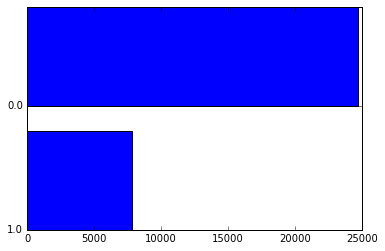

In [116]:
plot(lpointsLocal)

### Splitting the data into train and test data.

In [117]:
(trainingData, testData) = lpointsDF.randomSplit([0.7, 0.3])

### Building a Random tree classifier.

In [118]:
lpointsDF.cache()
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.tree import RandomForest, RandomForestModel
rf = RandomForestClassifier(labelCol="label",featuresCol='features')
#rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
model = rf.fit(trainingData)
predictions = model.transform(testData)

In [119]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

from pyspark.mllib.regression import LabeledPoint

(trainingDataRDD, testDataRDD) = (lpointsDF
                            .map(lambda x: LabeledPoint(x[1],x[0]))
                            .randomSplit([0.7, 0.3]))
mllibModel = RandomForest.trainClassifier(trainingDataRDD, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)
print(mllibModel.toDebugString())

TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 25 <= 0.0)
     If (feature 40 <= 0.0)
      If (feature 12 <= 0.0)
       If (feature 52 <= 0.0)
        Predict: 0.0
       Else (feature 52 > 0.0)
        Predict: 0.0
      Else (feature 12 > 0.0)
       If (feature 0 <= 30.0)
        Predict: 0.0
       Else (feature 0 > 30.0)
        Predict: 1.0
     Else (feature 40 > 0.0)
      If (feature 19 <= 0.0)
       If (feature 12 <= 0.0)
        Predict: 0.0
       Else (feature 12 > 0.0)
        Predict: 0.0
      Else (feature 19 > 0.0)
       If (feature 47 <= 0.0)
        Predict: 1.0
       Else (feature 47 > 0.0)
        Predict: 0.0
    Else (feature 25 > 0.0)
     If (feature 40 <= 0.0)
      If (feature 50 <= 0.0)
       If (feature 22 <= 0.0)
        Predict: 1.0
       Else (feature 22 > 0.0)
        Predict: 1.0
      Else (feature 50 > 0.0)
       If (feature 39 <= 0.0)
        Predict: 0.0
       Else (feature 39 > 0.0)
        Predict: 1.0
     Else (f

In [120]:
predictions.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(99,[0,1,4,5,6,13...|
|       0.0|  1.0|(99,[0,1,2,4,5,6,...|
|       0.0|  0.0|(99,[0,1,4,6,15,2...|
|       0.0|  0.0|(99,[0,1,4,5,6,10...|
|       0.0|  0.0|(99,[0,1,4,6,16,3...|
+----------+-----+--------------------+
only showing top 5 rows



In [121]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.173815
